#### **Team members**:  
#####           -Godwin Bime, 
#####           -Yin Yin Tan, 
#####           -Pratik Patel, 
#####           -Crystal Li

In [8]:
# !cp /content/drive/MyDrive/Colab\ Notebooks/SentimentAnalysis/Twitter_Data.csv /content/sample_data

In [9]:
# !cp /content/drive/MyDrive/Colab\ Notebooks/SentimentAnalysis/Reddit_Data.csv /content/sample_data

In [11]:
# cd sample_data/

In [72]:
# !cp /content/drive/MyDrive/Colab\ Notebooks/SentimentAnalysis/train_deploy.py /content/sample_data

In [13]:
# !cp /content/drive/MyDrive/Colab\ Notebooks/SentimentAnalysis/requirements.txt /content/sample_data

In [17]:
# !pip install -r requirements.txt

In [1]:
from logging import warning
import os
import numpy as np
import pandas as pd

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.huggingface import HuggingFace

import boto3
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

In [2]:
#  !aws configure

In [3]:
sagemaker_sess = sagemaker.Session()
bucket = sagemaker_sess.default_bucket()
prefix = "sagemaker/ai620-group-project"
print(f"\nSession-Name: {bucket}\n")
#role = sagemaker.get_execution_role()


Session-Name: sagemaker-us-east-1-060110317448



In [4]:
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='SageMakerNotebookRoleAI620gp')['Role']['Arn']

print(f"Role: {role}")

Role: arn:aws:iam::060110317448:role/SageMakerNotebookRoleAI620gp


In [5]:
column_names = ["Sentence", "Label"]  # ["Tweet_ID", "Entity", "Sentiment", "Tweet"]

### Tweeter dataset

In [6]:
# tweeter_df = pd.read_csv("/content/sample_data/Twitter_Data.csv", 
#                 #  header=None,
#                 #  usecols=[1, 3],        
#                  names=column_names)

### Reddit dataset

In [7]:
# reddit_df = pd.read_csv("/content/sample_data/Reddit_Data.csv", 
#                 #  header=None,
#                 #  usecols=[1, 3],        
#                  names=column_names)

In [8]:
# tweeter_df.head()

In [9]:
# reddit_df.head()

# Merging the Tweeter and Reddit datasets

In [10]:
# reddit_df.describe()

In [11]:
# merged_df = tweeter_df.merge(reddit_df, on=["Sentence", "Label"])

In [12]:
# merged_df.describe()

### Write the dataset into a new .csv file

In [13]:
# merged_df.to_csv("tweeter_and_reddit.csv")

In [14]:
df = pd.read_csv("/content/sample_data/Twitter_Data.csv", 
                #  header=None,
                #  usecols=[1, 3],        
                 names=column_names)

In [15]:
Sentences = df.Sentence.values
Labels = df.Label.values

In [16]:
df.head()

,Sentence,Label
0,clean_text,category
1,when modi promised “minimum government maximum...,-1
2,talk all the nonsense and continue all the dra...,0
3,what did just say vote for modi welcome bjp t...,1
4,asking his supporters prefix chowkidar their n...,1


In [17]:
df.isna().sum()

Sentence    4
Label       7
dtype: int64

In [18]:
df.dropna(inplace=True)

In [19]:
df.isna().sum()

Sentence    0
Label       0
dtype: int64

In [20]:
df.head()

,Sentence,Label
0,clean_text,category
1,when modi promised “minimum government maximum...,-1
2,talk all the nonsense and continue all the dra...,0
3,what did just say vote for modi welcome bjp t...,1
4,asking his supporters prefix chowkidar their n...,1


In [21]:
df['Sentence'].describe()

count         162970
unique        162970
top       clean_text
freq               1
Name: Sentence, dtype: object

In [22]:
list(zip(Sentences[80:85], Labels[80:85]))

[('kitna jalte tum modi your tweet shows your jealousy towards our great prime minister modi ',
  '1'),
 ('centre state govts working together make india tbfree 2025 ', '0'),
 ('where ever rgis going through out the length breadth the country such the reception for him masses india just love him modi all other leaders bjp are just match',
  '1'),
 ('mad sandip singh have some sense javed akhtar could have called narendra modi producer sandip ssingh credit row entertainment news the indian express ',
  '-1'),
 ('thanks modi porn sites are banned', '1')]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162970 entries, 0 to 162980
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Sentence  162970 non-null  object
 1   Label     162970 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


In [24]:
# pip install nltk

In [25]:
from nltk.corpus import stopwords
from nltk.stem.porter import *
import re
from bs4 import BeautifulSoup
import nltk
"""
The review_to_words method defined above uses BeautifulSoup to remove 
any html tags that appear and uses the nltk package to tokenize the reviews. 
As a check to ensure we know how everything is working, try applying review_to_words 
to one of the reviews in the training set.
"""

# Remove html tags, stop words, and convert to lower case
def review_input_words(input_review_words):
  nltk.download("stopwords", quiet=True)
  stemmer = PorterStemmer()

  text = BeautifulSoup(input_review_words, "html.parser").get_text()# Remove all the html tags
  text = re.sub(r"a-zA-Z0-9", " ", text.lower()) # Convert the cleaned text to lowercase
  words = text.split() # Split the strings into words
  words = [w for w in words if w not in stopwords.words("english")] # Remove all the stop words
  words = [PorterStemmer().stem(w) for w in words] 

  return words

In [26]:
# Helper function to remove URL from text, emojis and puctuatuins where necessary
def remove_URL(u_text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', u_text)

In [27]:
def remove_emojis(e_text):
  em_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"   # emojis
                            u"\U0001F300-\U0001F5FF"   # symbols and diagrams
                            u"\U0001F680-\U0001F6FF"   # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"   # flags (iOS)
                            u"\U00002702-\U000027B0"   # chinese char
                            u"\U000024C2-\U0001F251"
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                            "]+", flags=re.UNICODE)
  return em_pattern.sub(r'', e_text)

In [28]:
def remove_html(h_text):
  h_tag = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  h_text = h_tag.sub(r'', h_text)
  return h_text

In [29]:
def remove_punctuation(p_text):
  table = str.maketrans('', '', string.punctuation)
  return p_text.translate(table)

## Clean the data

In [30]:
df['Sentence'] = df['Sentence'].apply(lambda u_x: remove_URL(u_x))
df['Sentence'] = df['Sentence'].apply(lambda p_x: remove_punctuation(p_x))
df['Sentence'] = df['Sentence'].apply(lambda e_x: remove_emojis(e_x))
df['Sentence'] = df['Sentence'].apply(lambda h_x: remove_html(h_x))
#df['Sentence'] = df['Sentence'].apply(lambda r_x: review_input_words(r_x))

In [31]:
df.head()

,Sentence,Label
0,cleantext,category
1,when modi promised “minimum government maximum...,-1
2,talk all the nonsense and continue all the dra...,0
3,what did just say vote for modi welcome bjp t...,1
4,asking his supporters prefix chowkidar their n...,1


In [32]:
Sentences = df.Sentence.values
Labels = df.Label.values

In [33]:
list(zip(Sentences[80:85], Labels[80:85]))

[('kitna jalte tum modi your tweet shows your jealousy towards our great prime minister modi ',
  '1'),
 ('centre state govts working together make india tbfree 2025 ', '0'),
 ('where ever rgis going through out the length breadth the country such the reception for him masses india just love him modi all other leaders bjp are just match',
  '1'),
 ('mad sandip singh have some sense javed akhtar could have called narendra modi producer sandip ssingh credit row entertainment news the indian express ',
  '-1'),
 ('thanks modi porn sites are banned', '1')]

## Data Distribution

In [34]:
df["Sentence"][:5]

0                                            cleantext
1    when modi promised “minimum government maximum...
2    talk all the nonsense and continue all the dra...
3    what did just say vote for modi  welcome bjp t...
4    asking his supporters prefix chowkidar their n...
Name: Sentence, dtype: object

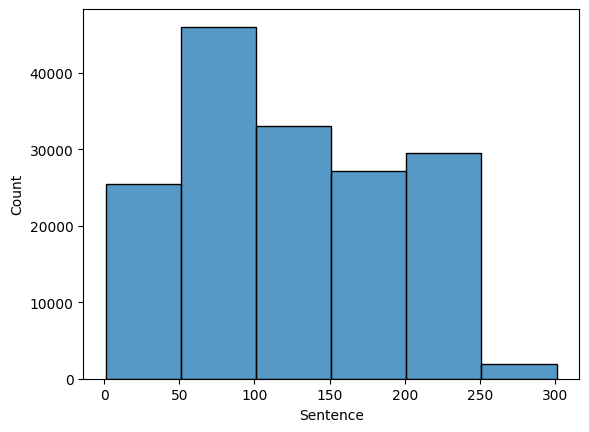

In [35]:
sns.histplot(df['Sentence'].str.len(), binwidth=50)
plt.show()

In [37]:
# fig, ax = plt.subplots(1, 2, figsize=(12,6))
# ax[0].pie(df['Label'].value_counts(), labels=df['Label'].value_counts().index, autopct='%.f%%')
# fig.suptitle("Proportions of target classes")
# ax[0].set_title("Train dataset")
# plt.show()

In [63]:
df.groupby('Label').describe()

Sentence                                                            \
            count unique                                                top   
Label                                                                         
-1          35509  35504  the modi govt approved scheduled tribe status ...   
0           55211  55183                                         only modi    
1           72249  72223  modi’ rally rudrapur people say ‘main bhi chow...   
category        1      1                                          cleantext   

               
         freq  
Label          
-1          2  
0           5  
1           2  
category    1

### Split the dataset for training and testing

In [47]:
train, test = train_test_split(df)
train.to_csv("/content/sample_data/train.csv")
test.to_csv("/content/sample_data/test.csv")

### Upload both train and test dataset to s3 bucket for later use

In [48]:
input_train = sagemaker_sess.upload_data("/content/sample_data/train.csv", bucket=bucket, key_prefix=prefix)
input_test = sagemaker_sess.upload_data("/content/sample_data/test.csv", bucket=bucket, key_prefix=prefix)

In [52]:
print(input_train)

s3://sagemaker-us-east-1-060110317448/sagemaker/ai620-group-project/train.csv


In [74]:
!pygmentize /content/sample_data/train_deploy.py

import argparse
import logging
import os
import random
import sys
import json
import numpy as np
import subprocess
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
import wandb

wandb.login(key="7c897087ac4638f26fb916ad0b8c4aa0437b64ad")  # Pass your W&B API key here
wandb.init(project="SentimentAnalysis")  # Add your W&B project name


# compute metrics function for binary classification
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


def train(args):
    # Set up logging
    logger = logging.getLogger(__name__)

    logging.basicConfig(
        le

### Training on Amazon SageMaker using on-demand instances with Epoch=2

In [77]:
estimator = PyTorch(entry_point="train_deploy.py",
                    source_dir="/content/sample_data",
                    role=role,
                    framework_version="1.9",
                    py_version="py38",
                    instance_count=1,
                    instance_type="ml.m5.xlarge",
                    Hyperparameters={"epochs": 2,
                                     "num_labels": 2,})

In [78]:
# estimator.fit({"training": input_train, "testing": input_test})
estimator.fit({"training": input_train, "testing": input_test})

Using provided s3_resource
2023-06-10 14:52:38 Starting - Starting the training job...
2023-06-10 14:52:53 Starting - Preparing the instances for training......
2023-06-10 14:54:10 Downloading - Downloading input data
2023-06-10 14:54:10 Training - Downloading the training image...
2023-06-10 14:54:41 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-10 14:54:50,252 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-06-10 14:54:50,255 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-10 14:54:50,263 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-06-10 14:54:50,266 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-06-10 14:54:51,210 sagemaker-training-toolkit INFO     Installing dependenc

### Training on Amazon SageMaker using spot instances

In [80]:
estimator = PyTorch(entry_point="train_deploy.py",
                    source_dir="/content/sample_data",
                    role=role,
                    framework_version="1.9",
                    py_version="py38",
                    instance_count=1,
                    instance_type="ml.m5.xlarge",
                    hyperparameters={"epochs": 2,
                                     "num_labels": 2,},
                    use_spot_instances=True,
                    max_run=4000,
                    max_wait=5000)

In [81]:
estimator.fit({"training": input_train, "testing": input_test})

Using provided s3_resource
2023-06-10 14:59:02 Starting - Starting the training job...
2023-06-10 14:59:17 Starting - Preparing the instances for training......
2023-06-10 15:00:24 Downloading - Downloading input data...
2023-06-10 15:00:45 Training - Downloading the training image...
2023-06-10 15:01:20 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-10 15:01:29,922 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-06-10 15:01:29,925 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-10 15:01:29,935 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-06-10 15:01:29,937 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-06-10 15:01:30,812 sagemaker-training-toolkit INFO     Installing depende

### Host the model on an Amazon SageMaker Endpoint

In [83]:
print(estimator)

In [84]:
# predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

In [ ]:
predictor.delete_endpoint()

## Reference
* - https://www.kaggle.com/code/jdparsons/tweet-cleaner
* - https://www.kaggle.com/code/vinayakshanawad/aws-sagemaker-train-deploy-update-a-bert-model
* - https://github.com/vinayak-shanawad/AWS-SageMaker-Examples/tree/main/05_SageMakerExperimentsWithWandB